# General fit example (2)

(model testing)

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
from ROOT import *
import numpy as np
from array import array
from scipy.stats import norm

# For inline image display
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 


### (2) Definition of model

Consider controlled parameter range is [0,1]

In [3]:
# True functional dependece baskground + two peaks

def mytrue(x):
    
    bg = 10.0 - 2* x + x*x
    
    sig1 = 20.0 * norm.pdf(x, loc=0.44, scale=0.05)
    
    sig2 = 5.0 * norm.pdf(x, loc=0.55, scale=0.10)

    return bg+sig1+sig2


# Basic function, return function values only
#
#  Parameters: 0 - 2 background
#              3 - 5 first peak
#              6 - 8 second peak
#
def myfun(x,par):

    npar = par.size   # should be 6 for sigle peak or 9 for double peak fit
    
    bg = par[0] + par[1]*x + par[2]*x*x
    
    if npar<6 :
        return bg
    
    sig1 = par[3] * norm.pdf(x, loc=par[4], scale=par[5])
    
    if npar<9 :
        return bg + sig1
    
    sig2 = par[6] * norm.pdf(x, loc=par[7], scale=par[8])

    return bg + sig1 + sig2

# Full model: returns values and derivatives

def myfunder(x,par):

    npar = par.size   # should be 6 for sigle peak or 9 for double peak fit

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,npar))

    # Background
    
    bg = par[0] + par[1]*x + par[2]*x*x
    
    der[:,0] = 1
    der[:,1] = x
    der[:,2] = x*x
   
    val += bg
    
    if npar < 6 :
        return val,der
    
    # First signal peak
    
    sig1 = norm.pdf(x, loc=par[4], scale=par[5])
    
    der[:,3] = sig1
    sig1 *= par[3]
    der[:,4] = (x-par[4])/par[5]/par[5]*sig1
    der[:,5] = (x-par[4])*(x-par[4])/par[5]/par[5]/par[5]*sig1
    
    val += sig1
    
    if npar < 9 :
        return val,der
    
    # Second signal peak
    
    sig2 = norm.pdf(x, loc=par[7], scale=par[8])
    
    der[:,6] = sig2
    sig2 *= par[6]
    der[:,7] = (x-par[7])/par[8]/par[8]*sig2
    der[:,8] = (x-par[7])*(x-par[7])/par[8]/par[8]/par[8]*sig2
    
    val += sig2
       
    return val,der

# myfunder(np.array([0.,0.25,0.5,0.75,1.]),np.array([2.,-1.,4.,10.,0.5,0.1,5.,0.7,0.2]))

### (3) Generate pseudo data to fit

In [4]:
# Considered values of x

xvec = np.linspace(0.025,0.975,20)

# Measurement precision

svec = np.linspace(2.,4.,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (4) Iterative fit

In [5]:
# Number of function parameters to consider  (3, 6 or 9)

Nfun = 9

# Initial guess for parameters

parini = np.zeros(Nfun)

# Background guess

parini[0] = 10.
parini[1] = -1.
parini[2] = +1.

# First peak guess

if Nfun >= 6 :
    parini[3] = 20.
    parini[4] = 0.4
    parini[5] = 0.1

# Second peak guess

if Nfun == 9 :
    parini[6] = 5.
    parini[7] = 0.5
    parini[8] = 0.1


# Initial function vales

# fini,dini = myfunder(xvec,parini) 
fini = myfun(xvec,parini) 

# Initial printout

chi2ini = np.sum((yvec-fini)**2/s2vec)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [10.  -1.   1.  20.   0.4  0.1  5.   0.5  0.1]
  chi^2 =  1718.505   chi^2/N = 85.92524 


In [6]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.0001   # Required precision (distance from minimum)

chi2min = chi2ini
parmin = parini

par = parini

Nit = 0
Nimp = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    dyvec = yvec-fval
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*dyvec/s2vec)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A
    for l in range(Nfun):
        C[l,l] *= 1 + lam
        
    # Inverse of matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    chi2new = np.sum((yvec-fnew)**2/s2vec)

    # Distance to minimum (assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1

    if (chi2new < chi2min and (Nimp<10 or Nimp%10==0)) or dist <= dcut :
        print("\nIteration step ",Nit," with lambda = ",lam)
        print(" ",parnew)
        print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2new,chi2new/(xvec.size-Nfun)))
        print("  distance to minimum: ",dist)
        
    if chi2new < chi2min :
        Nimp += 1
        lam /= 10
        chi2min = chi2new
        par = parnew
    else:
        lam *= 10



Iteration step  2  with lambda =  0.1
  [13.02784987  3.3557872  -3.72834626 19.54277031  0.47562452  0.08071296
  7.10402509  0.35824451  0.06710711]
  chi^2 =  1091.231   chi^2/N = 99.20282 
  distance to minimum:  353.8551181656529

Iteration step  4  with lambda =  0.1
  [ 9.86793435  5.07358267 -3.0494531  18.47364723  0.45571479  0.07102236
  3.26912945  0.44678264  0.10629648]
  chi^2 =   535.845   chi^2/N = 48.71319 
  distance to minimum:  375.1357126682469

Iteration step  6  with lambda =  0.1
  [10.00713429  7.62120135 -6.5242571  22.40901852  0.43133882  0.04978241
  6.20471453  0.61487233  0.10793058]
  chi^2 =   234.858   chi^2/N = 21.35074 
  distance to minimum:  220.77706500196317

Iteration step  7  with lambda =  0.01
  [ 9.25701128  4.93770024 -9.43911234 19.10677899  0.43854172  0.04924146
  5.19561787  0.56216687  0.14623169]
  chi^2 =    47.230   chi^2/N =  4.29363 
  distance to minimum:  66.55632665930965

Iteration step  8  with lambda =  0.001
  [ 9.1857815

In [7]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     9.271  +/-  2.138 
     2.778  +/- 23.270 
    -5.433  +/- 22.695 
    19.066  +/-  0.959 
     0.440  +/-  0.001 
     0.049  +/-  0.002 
     6.910  +/-  2.053 
     0.553  +/-  0.041 
     0.122  +/-  0.033 

 Correlation matrix

[ 1.    -0.856  0.823 -0.338  0.128 -0.225  0.564 -0.319  0.548]
[-0.856  1.    -0.991  0.578 -0.197  0.407 -0.794  0.569 -0.808]
[ 0.823 -0.991  1.    -0.593  0.178 -0.42   0.797 -0.6    0.79 ]
[-0.338  0.578 -0.593  1.    -0.11   0.707 -0.831  0.917 -0.694]
[ 0.128 -0.197  0.178 -0.11   1.     0.005 -0.025 -0.093  0.443]
[-0.225  0.407 -0.42   0.707  0.005  1.    -0.742  0.82  -0.531]
[ 0.564 -0.794  0.797 -0.831 -0.025 -0.742  1.    -0.824  0.711]
[-0.319  0.569 -0.6    0.917 -0.093  0.82  -0.824  1.    -0.647]
[ 0.548 -0.808  0.79  -0.694  0.443 -0.531  0.711 -0.647  1.   ]

 chi^2 =     9.485   chi^2/Ndf =  0.86230 


### (5) Draw data and fit

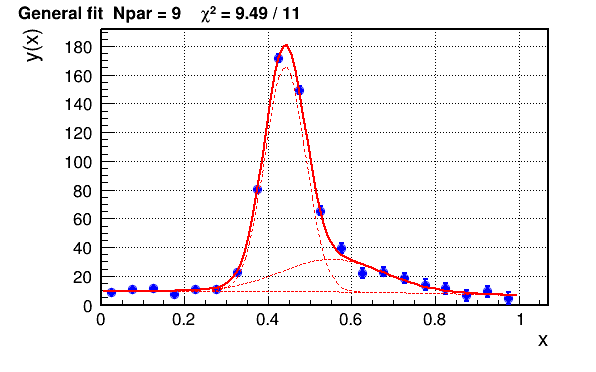

Info in <TCanvas::Print>: png file 08_fit3_9.png has been created


In [8]:
# Lin scale

gStyle.SetOptLogy(0)

# Create plot canvas

# gStyle.SetCanvasDefH(600)  # Default is 600 x 400

cexp = TCanvas('cexp')
   
## Pseudo-data graph

dgr=TGraphErrors(xvec.size,array('d',xvec),array('d',yvec),0,array('d',svec))
dgr.SetNameTitle('dgr','General fit  Npar = '+str(Nfun)+'     #chi^{2} = '+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun))
    
# Graphic style

dgr.GetXaxis().SetTitle("x")
dgr.GetYaxis().SetTitle("y(x)")
dgr.SetMarkerStyle(20)
dgr.SetMarkerSize(1.0)
dgr.SetMarkerColor(4)
dgr.SetLineColor(4)
dgr.SetLineWidth(2)
dgr.SetLineStyle(1)
dgr.SetMinimum(0.)   
dgr.Draw('AWP')

# Fitted dependence wraper for root

def myfit(x, fpar):
    
    xvec = np.array([x[0]])

    tpar = np.empty(par.size)
    for ip in range(par.size): tpar[ip]=fpar[ip]
    
    val = myfun(xvec,tpar)
        
    return val

# Define user function

fexp=TF1("fexp",myfit,-1.,1.,Nfun)

for ip in range(Nfun):
    fexp.SetParameter(ip,par[ip])
    
fexp.SetNpx(100)
fexp.SetLineStyle(1)
fexp.SetLineColor(2)

fexp.DrawCopy("Lsame")

# Draw separate peaks

if Nfun > 3:
    fexp.SetLineWidth(1)
    fexp.SetLineStyle(2)
    fexp.SetLineColor(2)
    fexp.SetParameter(3,0.)
    fexp.SetParameter(6,0.)
    fexp.DrawCopy("Lsame")
    
if Nfun > 6:
    fexp.SetParameter(3,par[3])
    fexp.DrawCopy("Lsame")
    fexp.SetParameter(3,0.)
    fexp.SetParameter(6,par[6])
    fexp.DrawCopy("Lsame")
    
cexp.Update()
fname = '08_fit3_'+str(Nfun)+'.png'
cexp.Print(fname)

Image(filename=fname)